# Compile the main simulator code using cython 

In [1]:
!python setup.py build_ext --inplace

Compiling agent_timestep_plasticity.pyx because it changed.
[1/1] Cythonizing agent_timestep_plasticity.pyx
/home/jyotika/Utils/envs/cbgtpy_env/lib/python3.8/site-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /home/jyotika/Work/CBGTPy_release/CBGTPy/agent_timestep_plasticity.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'agent_timestep_plasticity' extension
gcc -pthread -B /home/jyotika/Utils/envs/cbgtpy_env/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/jyotika/Utils/envs/cbgtpy_env/include/python3.8 -c agent_timestep_plasticity.c -o build/temp.linux-x86_64-cpython-38/agent_timestep_plasticity.o
gcc -pthread -shared -B /home/jyotika/Utils/envs/cbgtpy_env/compiler_compat -L/home/jyotika/Utils/envs/cbgtpy_env/lib -Wl,-rpath=/home/jyotika/Utils/envs/cbgtpy_env/lib -W

# Import all the relevant files 

In [25]:
# Import the pipeline creation object
import pandas as pd
import numpy as np
import cbgt as cbgt
import pipeline_creation as pl_creat
import plotting_functions as plt_func
import plotting_helper_functions as plt_help
import postprocessing_helpers as post_help


import importlib

importlib.reload(plt_help)
importlib.reload(plt_func)
importlib.reload(post_help)

%load_ext autoreload
%autoreload 2
%reload_ext autoreload 

import warnings
warnings.simplefilter('ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Choose the experiment and create the main pipeline

In [3]:
#Choose the experiment:
experiment_choice = 'n-choice'

if experiment_choice == 'stop-signal':
    import paramfile_stopsignal as paramfile
elif experiment_choice == 'n-choice':
    import paramfile_nchoice as paramfile
    
number_of_choices = 2

#Choose which multiprocessing library to use
use_library = "pathos" # "none" or "pathos" or "ray"

# Call choose_pipeline with the pipeline object
pl_creat.choose_pipeline(experiment_choice)

#Create the main pipeline
pl = pl_creat.create_main_pipeline(runloop=True)

# how many simulations do you want to run ? each simulation is executed as a seperate thread

num_sims = 1

num_cores = 7
# set a seed
import time
np.random.seed(int(time.time()))
#seed = np.random.choice(np.random.randint(0,9999999,100),1)[0]
seed = 8867366
print(seed)


in choose pipeline
in reward pipeline
8867366


In [4]:

# Define the data and figure directory

data_dir = "./Data/"
figure_dir = "./Figures/"


# Modify cellular parameters as desired. 
### The paramfile has all the parameter dictionaries that can be modified. They are listed as below:
- celldefaults (neuronal parameters)
- d1defaults (dSPN parameters)
- d2defaults (iSPN parameters)
- dpmndefaults (dopamine related parameters)
- basestim (background input for the nuclei)
- popspecific (population specific parameters)
- receptordefaults (GABA, AMPA receptor parameters)
### The details of each of these dictionaries can be checked by simply typing paramfile.<parameter name> as also shown in the block below

In [5]:
# list out the available parameter dictionaries
dir(paramfile)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'basestim',
 'celldefaults',
 'd1defaults',
 'd2defaults',
 'dpmndefaults',
 'np',
 'pd',
 'popspecific',
 'receptordefaults']

In [6]:
# view (or edit) one of the parameter dictionaries
paramfile.celldefaults


{'N': 75,
 'C': 0.5,
 'Taum': 20,
 'RestPot': -70,
 'ResetPot': -55,
 'Threshold': -50,
 'RestPot_ca': -85,
 'Alpha_ca': 0.5,
 'Tau_ca': 80,
 'Eff_ca': 0.0,
 'tauhm': 20,
 'tauhp': 100,
 'V_h': -60,
 'V_T': 120,
 'g_T': 0,
 'g_adr_max': 0,
 'Vadr_h': -100,
 'Vadr_s': 10,
 'ADRRevPot': -90,
 'g_k_max': 0,
 'Vk_h': -34,
 'Vk_s': 6.5,
 'tau_k_max': 8,
 'n_k': 0,
 'h': 1}

### To change a parameter, simply assign the desired value to the parameter
### eg. paramfile.celldefaults['C'] = 0.5

In [7]:
# paramfile.celldefaults['C'] = 0.5

# Running the pipeline

### 1. Default values of environment variable

In [8]:
#See init_params.py / generateepochs.py / popconstruct.py / qvalues.py
#to know the parameters contained in each of the following variables 
configuration = {
    'experimentchoice': experiment_choice,
    'inter_trial_interval': None, # default = 600ms
    'thalamic_threshold': None, # default 30sp/s
    'movement_time':None,# #default sampled from N(250,1.5), ["constant",250], ["mean",250]
    'choice_timeout':None, #wait for a choice to be made, default 1000, 
    'params': paramfile.celldefaults,  #neuron parameters
    'pops': paramfile.popspecific,    #population parameters
    'receps' : paramfile.receptordefaults, #receptor parameters
    'base' : paramfile.basestim,   #baseline stimulation parameters
    'dpmns' : paramfile.dpmndefaults,  #dopamine related parameters
    'd1' : paramfile.d1defaults,     #dSPNs population related parameters
    'd2' : paramfile.d2defaults,     #iSPNs population related parameters
    'channels' : pd.DataFrame([["left"],["right"]], columns=['action']), #action channels related parameters (init_params.py)
    'number_of_choices':number_of_choices,
    #'actionchannels' : pd.DataFrame([[1],[2]], columns=['action']), #labels for the actions (init_params.py)
    #'actionchannels' : pd.DataFrame([["left"],["right"]], columns=['action']), #labels for the actions (init_params.py)
    'newpathways' :[['Cx', 'dSPN', 'AMPA', 'syn', 1, 0.016, True],['GPe', 'FSI', 'GABA', 'all', 1, 0.1, False]],
    'Q_support_params': None,#pd.DataFrame([[85,0.6]],columns=['dpmn_CPP_scale','q_alpha']), #initialization of Q-values update (qvalues.py) 
    'Q_df_set':pd.DataFrame([[0.5, 0.5]],columns=["left","right"]), #initialized Q-values df (qvalues.py)  
    'n_trials': 2, #number of trials (generateepochs.py)
    'volatility': [2,"exact"], #frequency of changepoints and type of change points (exact or poisson) (generateepochs.py)
    'conflict': (0.7, 0.3), #probability of the preferred choice (generateepochs.py)
    'reward_mu': 1, #mean for the magnitude of the reward (generateepochs.py)
    'reward_std': 0.01, #std for the magnitude of the reward (generateepochs.py)
    'maxstim': 0.8, # 3 instead? how much stimulus the LIP gets at maximum
    'corticostriatal_plasticity_present':True, # whether plasticity is on or "off" at corticostriatal synapses
    'record_variables':["weight","optogenetic_input"],#"optogenetic_input"],
    'opt_signal_present':[False],
    'opt_signal_probability':[[1]], # probability of trials that will get the optogenetic signal / list of trial numbers
    'opt_signal_amplitude':[-0.5], # ampitude of the stop signal over base line
    'opt_signal_onset':[10.], # in ms
    'opt_signal_duration':["phase 0"],
    'opt_signal_channel': ["all"], # "all" (all channels are given the stop signal) 
    'opt_signal_population':["dSPN"],
    'sustainedfraction':0.7
                                #/"any" (channel given the stop signal is chosen randomly)
                                # [list of channels] == subset of channels given the stop signal
    
}


### Run the simulation - num_sims thread with the environment variable

In [9]:
results = cbgt.ExecutionManager(cores=num_cores,use=use_library).run([pl]*num_sims,[configuration]*num_sims)


in choose pipeline
SpawnThreadManagers <backend.Pipeline object at 0x7f9b70e95ca0>
change points:
 [0 1]
conflict (0.7, 0.3)
conflict (0.7, 0.3)
sum 1.0
n_prob_trials [0, 0]
calc_rew    left  right
0   0.0    0.0
reward_list    left  right
0   0.0    0.0scaling_conn 1.0
scaling_wts 1SpawnThreadManagers <backend.Pipeline object at 0x7f9b70e95d90>

begin GenOptSchedule
<class 'list'>
[1]
pop d
True
pop S
True
pop P
True
pop N
True
opt_amplitude_dfs [   left  right  trial_num
0  -0.5   -0.5          0
1  -0.5   -0.5          1]
opt_df
   opt_signal_present opt_signal_probability opt_signal_channel  \
0               False                    [1]                all   

  opt_signal_population  
0                  dSPN  
opt_channels_df
[    left  right  trial_num
0  False  False          0
1   True   True          1]
scaling_conn 1.0
scaling_wts 1
   src  dest receptor type  con    eff  plastic
0   Cx  dSPN     AMPA  syn    1  0.016     True
1  GPe   FSI     GABA  all    1  0.100    False
c

In [10]:
# List all the agent variables accessible
results[0].keys()

dict_keys(['experimentchoice', 'inter_trial_interval', 'thalamic_threshold', 'movement_time', 'choice_timeout', 'params', 'pops', 'receps', 'base', 'dpmns', 'd1', 'd2', 'channels', 'number_of_choices', 'newpathways', 'Q_support_params', 'Q_df_set', 'n_trials', 'volatility', 'conflict', 'reward_mu', 'reward_std', 'maxstim', 'corticostriatal_plasticity_present', 'record_variables', 'opt_signal_present', 'opt_signal_probability', 'opt_signal_amplitude', 'opt_signal_onset', 'opt_signal_duration', 'opt_signal_channel', 'opt_signal_population', 'sustainedfraction', 'par', 'popconstruct', 'interface', 'actionchannels', 'trial_wise_movement_times', 'volatile_pattern', 'cp_idx', 'cp_indicator', 'noisy_pattern', 't_epochs', 'block', 'trial_num', 'chosen_action', 'celldefaults', 'popspecific', 'receptordefaults', 'basestim', 'dpmndefaults', 'd1defaults', 'd2defaults', 'popdata', 'pathways', 'opt_df', 'opt_channels_dfs', 'opt_amplitude_dfs', 'opt_onset_dfs', 'opt_duration_dfs', 'opt_populations_df

In [11]:
# pd.concat([results[0]['pathways'],pd.DataFrame(results[0]['newpathways'].iloc[0]).transpose()]).reset_index()

In [12]:
# pd.DataFrame(results[0]['newpathways'].iloc[0]).transpose()
results[0]['pathways']

,index,src,dest,receptor,type,con,eff,plastic,biselector
0,0`,Cx`,dSPN`,AMPA`,syn`,1.0`,0.016`,True`,<function MatchBiselector.<locals>.Biselector ...
1,1`,Cx`,dSPN`,NMDA`,syn`,1.0`,0.02`,False`,<function MatchBiselector.<locals>.Biselector ...
2,2`,Cx`,iSPN`,AMPA`,syn`,1.0`,0.015`,True`,<function MatchBiselector.<locals>.Biselector ...
3,3`,Cx`,iSPN`,NMDA`,syn`,1.0`,0.02`,False`,<function MatchBiselector.<locals>.Biselector ...
4,4`,Cx`,FSI`,AMPA`,all`,1.0`,0.19`,False`,<function MatchBiselector.<locals>.Biselector ...
5,5`,Cx`,Th`,AMPA`,syn`,1.0`,0.025`,False`,<function MatchBiselector.<locals>.Biselector ...
6,6`,Cx`,Th`,NMDA`,syn`,1.0`,0.029`,False`,<function MatchBiselector.<locals>.Biselector ...
7,7`,dSPN`,dSPN`,GABA`,syn`,0.45`,0.28`,False`,<function MatchBiselector.<locals>.Biselector ...
8,8`,dSPN`,iSPN`,GABA`,syn`,0.45`,0.28`,False`,<function MatchBiselector.<locals>.Biselector ...
9,9`,dSPN`,GPi`,GABA`,syn`,1.0`,2.09`,False`,<function MatchBiselector.<locals>.Biselector ...


In [13]:
results[0]['conflict']

(0.7, 0.3)

In [14]:
results[0]['Q_df']

,left,right
0,0.500,0.5
0,0.450,0.5
0,0.405,0.5


In [15]:
experiment_choice

'n-choice'

In [26]:
#Extract all the relevant dataframes
firing_rates, reward_q_df, performance, rt_dist, total_performance = plt_help.extract_relevant_frames(results,seed,experiment_choice)

In [27]:
results[0]['popfreqs']

,GPi_left,GPi_right,STN_left,STN_right,GPe_left,GPe_right,dSPN_left,dSPN_right,iSPN_left,iSPN_right,Cx_left,Cx_right,Th_left,Th_right,FSI_common,CxI_common,Time (ms)
0,16.666667,48.222222,32.933333,29.866667,42.088889,50.466667,25.777778,15.555556,22.000000,18.888889,0.000000,0.000000,35.777778,20.222222,0.0,0.896057,0
1,16.444444,48.000000,32.844444,29.933333,42.688889,50.000000,26.000000,16.000000,22.444444,18.888889,0.000000,0.000000,35.777778,19.555556,0.0,0.896057,1
2,16.222222,47.777778,32.888889,30.066667,42.822222,50.355556,26.444444,15.555556,22.444444,18.888889,0.000000,0.000000,35.333333,18.888889,0.0,0.896057,2
3,16.000000,46.888889,32.733333,30.266667,42.577778,51.111111,26.888889,15.555556,22.888889,18.000000,0.000000,0.000000,35.333333,18.888889,0.0,0.985663,3
4,15.777778,46.666667,33.244444,30.022222,41.933333,52.133333,26.888889,16.000000,22.888889,18.000000,0.000000,0.000000,36.222222,19.111111,0.0,0.985663,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1705,41.333333,27.555556,27.933333,36.377778,56.644444,36.600000,17.333333,24.888889,17.111111,26.888889,1.715686,2.205882,20.222222,33.777778,0.0,2.060932,1705
1706,41.111111,28.444444,27.844444,36.777778,57.133333,35.666667,17.555556,24.888889,17.555556,27.333333,1.633987,2.287582,20.444444,33.777778,0.0,2.240143,1706
1707,40.888889,28.444444,27.777778,37.088889,57.555556,35.488889,18.000000,24.000000,17.333333,27.111111,1.552288,2.124183,20.666667,33.777778,0.0,2.240143,1707
1708,39.777778,28.888889,27.422222,37.022222,57.688889,35.466667,18.222222,24.666667,17.333333,27.111111,1.552288,2.124183,20.666667,33.333333,0.0,2.240143,1708


In [28]:
# firing rates  
firing_rates[0]

,Time (ms),variable,firing_rate,nuclei,channel,seed,n_trials,volatility,volatility_type,conflict
0,0,GPi_left,16.666667,GPi,left,8867366_0,2.0,2,exact,"(0.7, 0.3)"
1,1,GPi_left,16.444444,GPi,left,8867366_0,2.0,2,exact,"(0.7, 0.3)"
2,2,GPi_left,16.222222,GPi,left,8867366_0,2.0,2,exact,"(0.7, 0.3)"
3,3,GPi_left,16.000000,GPi,left,8867366_0,2.0,2,exact,"(0.7, 0.3)"
4,4,GPi_left,15.777778,GPi,left,8867366_0,2.0,2,exact,"(0.7, 0.3)"
...,...,...,...,...,...,...,...,...,...,...
27355,1705,CxI_common,2.060932,CxI,common,8867366_0,2.0,2,exact,"(0.7, 0.3)"
27356,1706,CxI_common,2.240143,CxI,common,8867366_0,2.0,2,exact,"(0.7, 0.3)"
27357,1707,CxI_common,2.240143,CxI,common,8867366_0,2.0,2,exact,"(0.7, 0.3)"
27358,1708,CxI_common,2.240143,CxI,common,8867366_0,2.0,2,exact,"(0.7, 0.3)"


In [29]:
performance

,%_rewarded_actions,%_action,actions,block,seed,n_trials,volatility,volatility_type,conflict,condition
0,0.0,50.0,left,left,8867366_0,2.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
1,0.0,50.0,left,right,8867366_0,2.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation


In [30]:
recorded_variables = post_help.extract_recording_variables(results,results[0]['record_variables'],seed)

['left' 'right']
nuc_list ['dSPN-left' 'iSPN-left' 'dSPN-right' 'iSPN-right']
ind_list [[0 0 1 0]
 [0 1 1 1]]


In [31]:
recorded_variables['weight']

,weights,trials,nuclei,seed
0,0.005601,0,dSPN-left,8867366_0
0,0.029075,0,iSPN-left,8867366_0
0,0.014979,0,dSPN-right,8867366_0
0,0.019941,0,iSPN-right,8867366_0


In [32]:
# recorded_variables['optogenetic_input']

<Axes: xlabel='trials', ylabel='weights'>

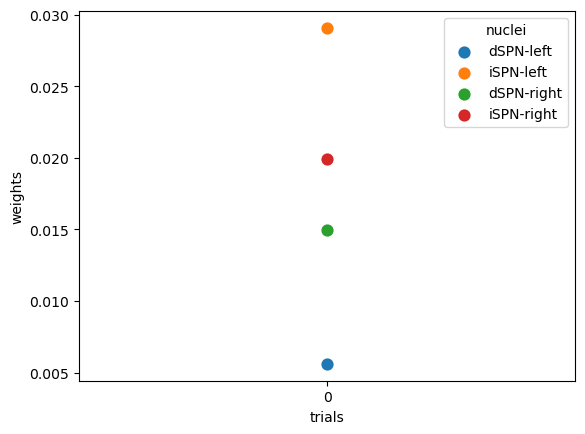

In [33]:
import seaborn as sns
import pylab as pl
sns.pointplot(x="trials",y="weights",hue="nuclei",data=recorded_variables['weight'])


<Axes: xlabel='Time(ms)', ylabel='value'>

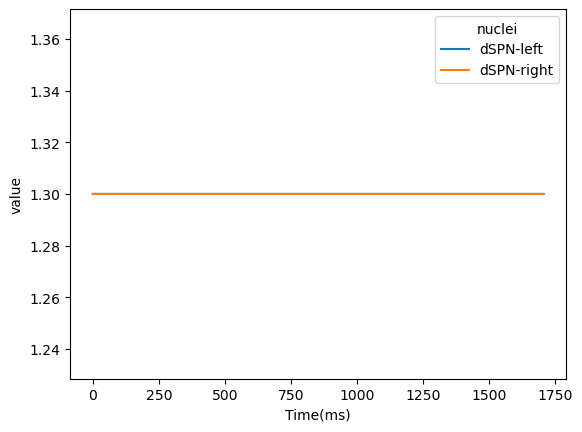

In [34]:
pl.figure()
sns.lineplot(x="Time(ms)",y="value",data=recorded_variables['optogenetic_input'],hue='nuclei')

In [35]:
# Relevant reward_dataframe
reward_q_df[0]

,level_0,index,Trials,variable,value,data_type,seed,n_trials,volatility,volatility_type,conflict,condition
0,0,3,0,left,0.500,Q_df,8867366_0,2.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
1,1,4,1,left,0.450,Q_df,8867366_0,2.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
2,2,5,2,left,0.405,Q_df,8867366_0,2.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
3,3,6,0,right,0.500,Q_df,8867366_0,2.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
4,4,7,1,right,0.500,Q_df,8867366_0,2.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
5,5,8,2,right,0.500,Q_df,8867366_0,2.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
6,0,0,0,left,0.000,reward_df,8867366_0,2.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
7,1,1,1,left,0.000,reward_df,8867366_0,2.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
8,2,2,0,right,0.000,reward_df,8867366_0,2.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
9,3,3,1,right,0.000,reward_df,8867366_0,2.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation


In [36]:
performance

,%_rewarded_actions,%_action,actions,block,seed,n_trials,volatility,volatility_type,conflict,condition
0,0.0,50.0,left,left,8867366_0,2.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation
1,0.0,50.0,left,right,8867366_0,2.0,2,exact,"(0.7, 0.3)",dSPN-Stimulation


In [37]:
# Extract the data tables from the agent
datatables = cbgt.collateVariable(results,'datatables')
datatables[0]["decisiondurationplusdelay"]-datatables[0]["decisionduration"]

0    252
1    253
dtype: object

In [38]:
datatables[0]

,decision,stimulusstarttime,decisiontime,decisionduration,decisiondurationplusdelay,rewardtime,correctdecision,reward
0,left,0,1,1,253,253,left,0.0
1,left,854,855,1,254,1108,right,0.0


In [39]:
# Check the Q-values data frame
results[0]['Q_df']

,left,right
0,0.500,0.5
0,0.450,0.5
0,0.405,0.5


In [40]:
# postfix = "weak_GPi_inh"
postfix = ""

In [41]:
#Save the selected variables of results in the data_dir specified
cbgt.saveResults(results,data_dir+'network_data_'+postfix+'_'+str(seed)+'.pickle',['popfreqs','popdata','Q_support_params','d1','d2','dpmns','datatables'])


In [42]:
firing_rates[0].to_csv(data_dir+"firing_rates_"+postfix+".csv")
reward_q_df[0].to_csv(data_dir+"reward_df_"+postfix+".csv")
performance.to_csv(data_dir+"performance_"+postfix+".csv")
rt_dist.to_csv(data_dir+"rt_dist_"+postfix+".csv")
total_performance.to_csv(data_dir+"total_performance_"+postfix+".csv")

In [43]:
reward_q_df

[    level_0  index  Trials variable  value      data_type       seed  \
 0         0      3       0     left  0.500           Q_df  8867366_0   
 1         1      4       1     left  0.450           Q_df  8867366_0   
 2         2      5       2     left  0.405           Q_df  8867366_0   
 3         3      6       0    right  0.500           Q_df  8867366_0   
 4         4      7       1    right  0.500           Q_df  8867366_0   
 5         5      8       2    right  0.500           Q_df  8867366_0   
 6         0      0       0     left  0.000      reward_df  8867366_0   
 7         1      1       1     left  0.000      reward_df  8867366_0   
 8         2      2       0    right  0.000      reward_df  8867366_0   
 9         3      3       1    right  0.000      reward_df  8867366_0   
 10        0      0       0     left  0.000  chosen action  8867366_0   
 11        1      1       1     left  0.000  chosen action  8867366_0   
 12        0      0       0     left  0.000        

/home/jyotika/Utils/envs/cbgtpy_env/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


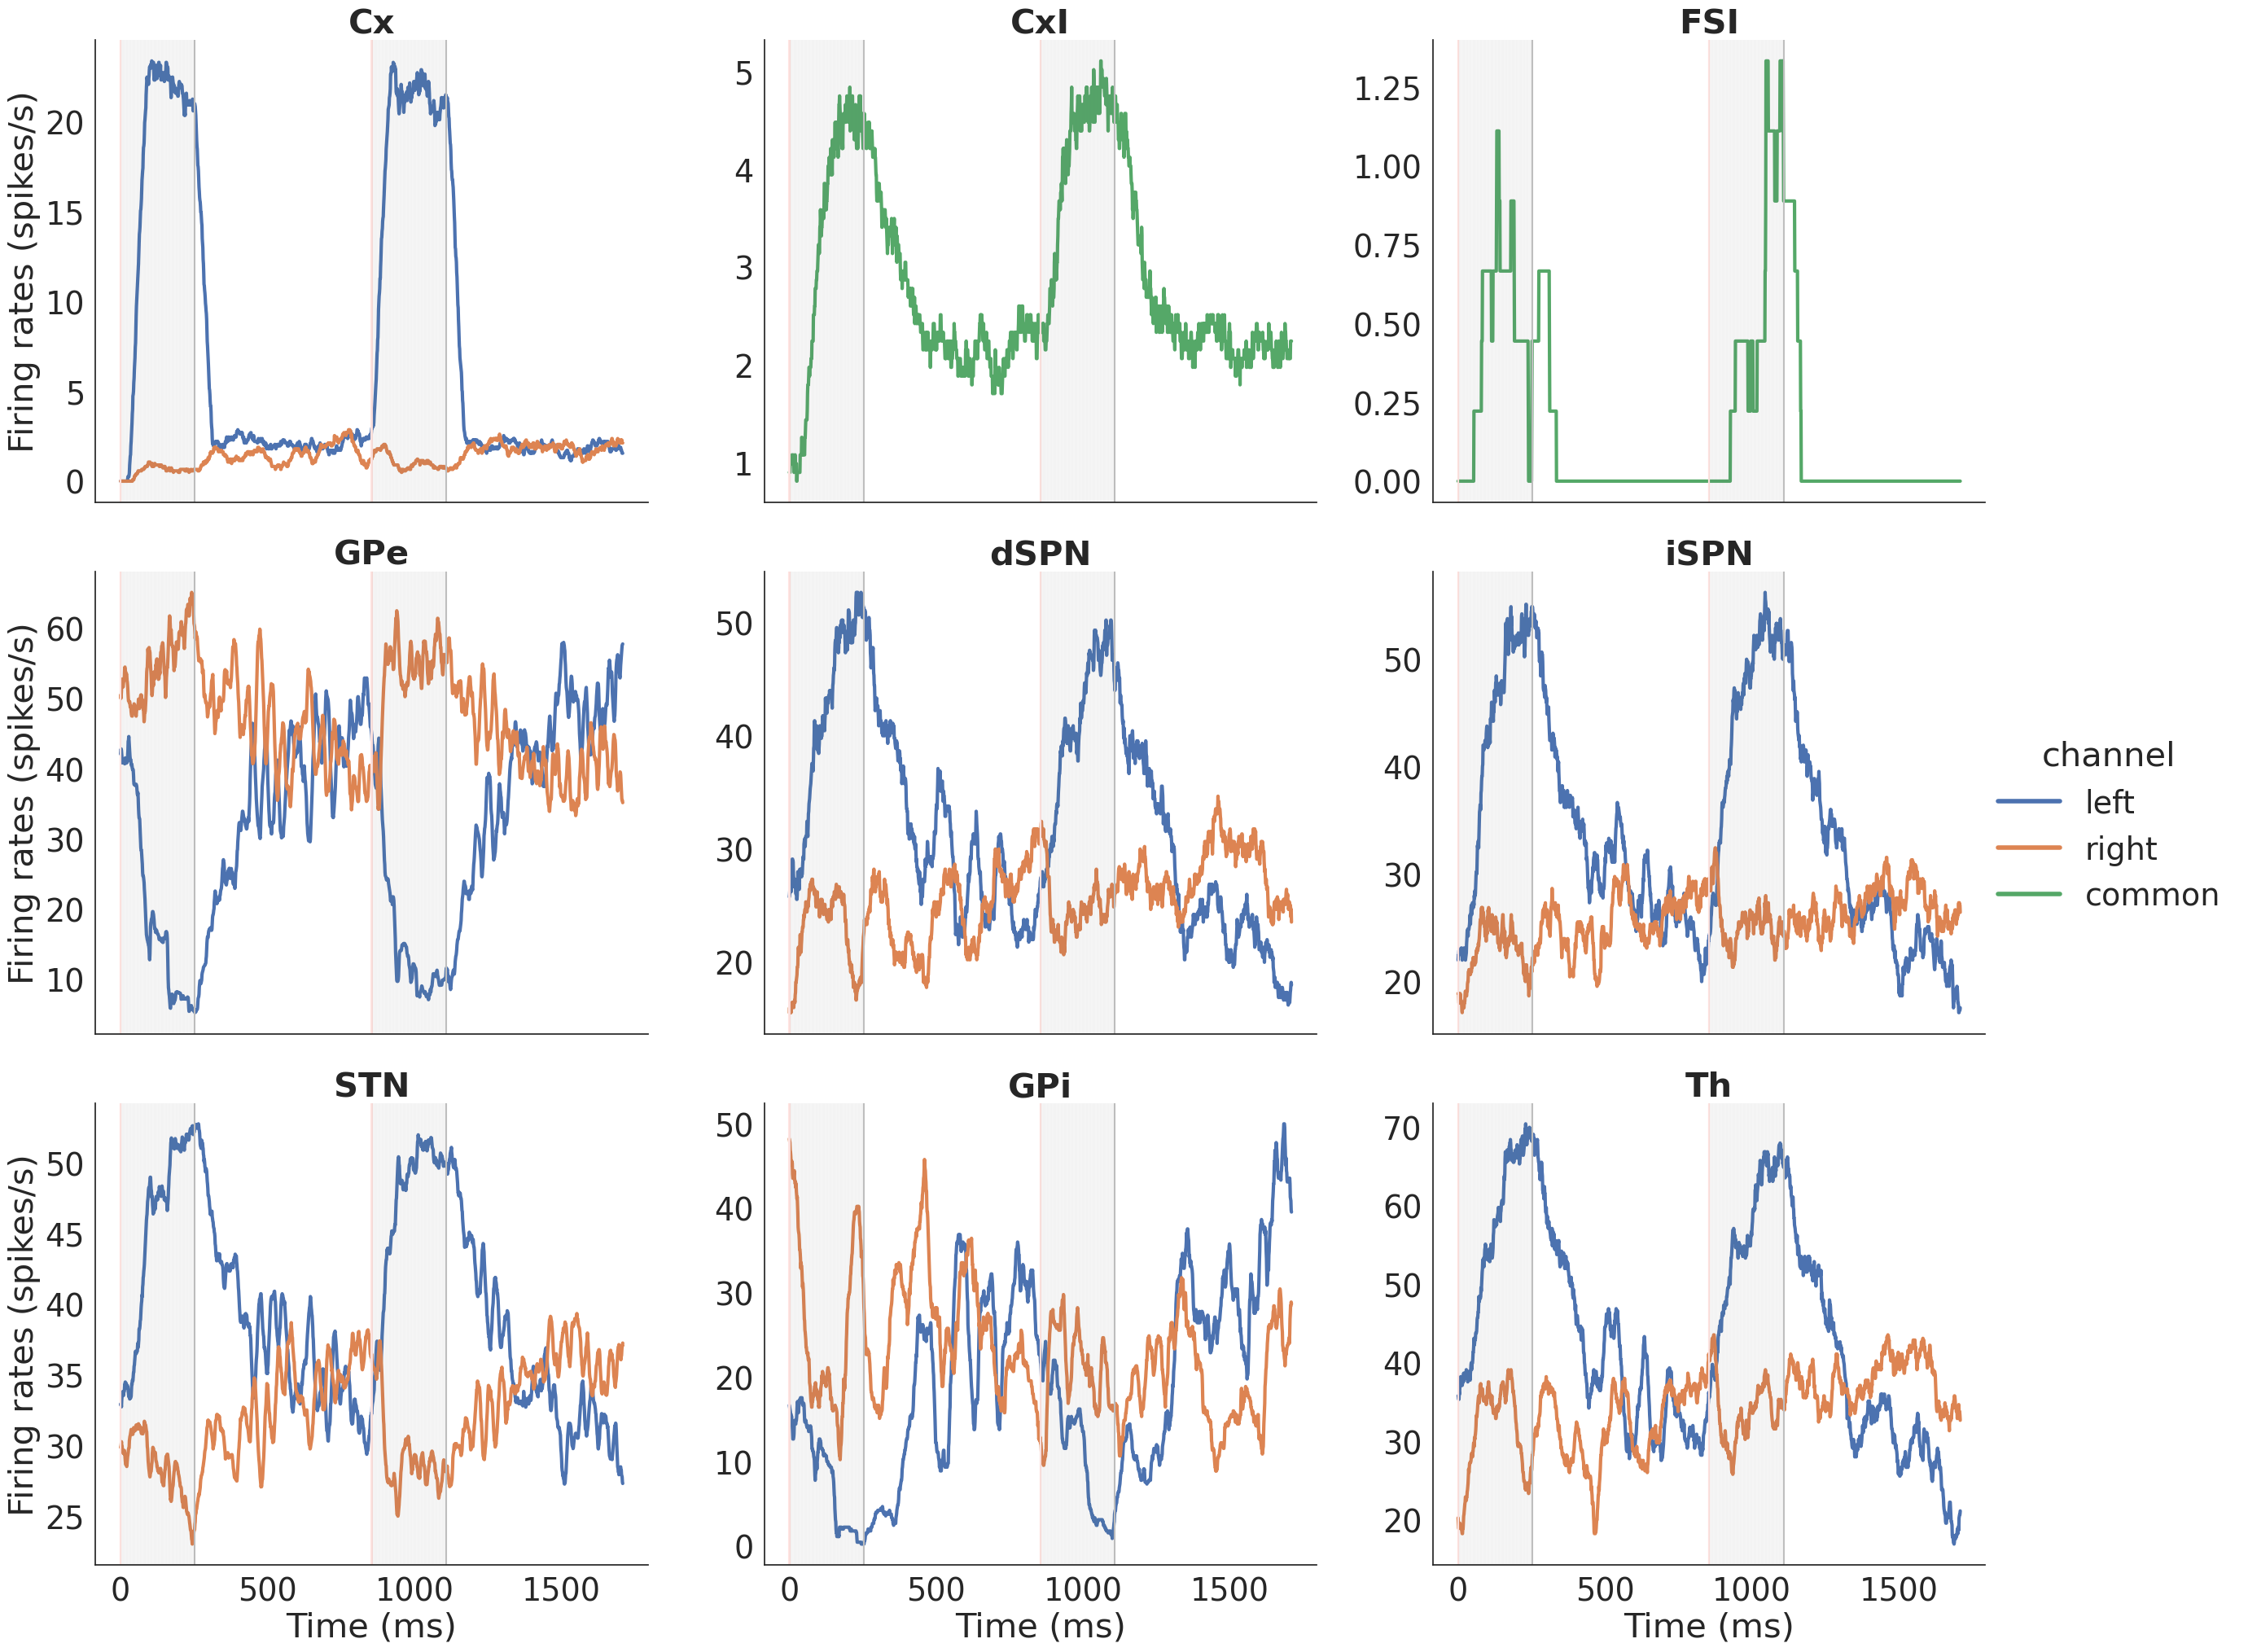

In [44]:
# Plot the firing rates extracted, figure handles are returned in fig_handles

FR_fig_handles = plt_func.plot_fr(firing_rates,datatables,results,experiment_choice,True)
# FR_fig_handles[0].savefig(figure_dir+"Example_FR_new_pathways_"+postfix+".png",dpi=400)

In [36]:
# FR_fig_handles_zoom = plt_func.plot_fr_flex(firing_rates[0],datatables[0],['all'], [], (0, 500)) 

{'left': (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), 'right': (0.8666666666666667, 0.5176470588235295, 0.3215686274509804)}


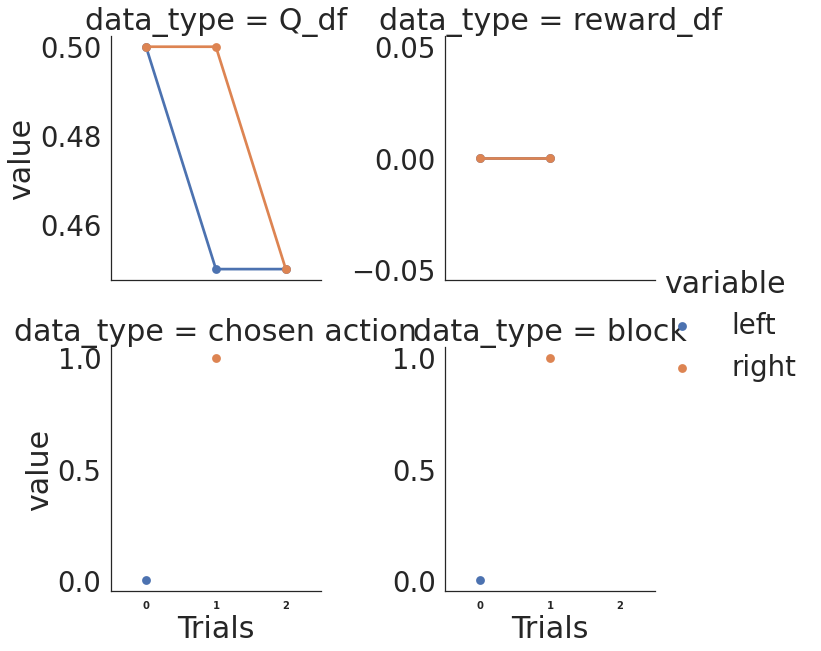

In [37]:
reward_fig_handles = plt_func.plot_reward_Q_df(reward_q_df)